In [1]:
# necessary import
import pickle # to manipulate models
import zipfile # to manipulate .zip file
import xgboost as xgb # for gradient boosting classifier
import numpy as np # for matrices and numerical manipulations
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plots
import seaborn as sns # for visualizing data

from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error# for feature importance
from sklearn.feature_extraction import DictVectorizer # for One-Hot Encoding
from sklearn.model_selection import train_test_split, KFold # for cross-validation techniques
from sklearn.linear_model import LogisticRegression # for logistic regression model
from sklearn.tree import DecisionTreeClassifier # for decision trees
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # for random forest classifier

from xgboost import XGBClassifier, XGBRegressor

%matplotlib inline

In [2]:
# Import only to get versions
import sys # for the system
import matplotlib, sklearn # for visualization and modelisation library

In [3]:
# System versions
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---" * 47)

# Libraries versions
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("xgboost version:", xgb.__version__)
print("sklearn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)

Platform: linux
Python version: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
---------------------------------------------------------------------------------------------------------------------------------------------
matplotlib version: 3.10.7
seaborn version: 0.13.2
xgboost version: 3.1.1
sklearn version: 1.6.1
pandas version: 2.3.3
numpy version: 2.2.6


In [4]:
weather = pd.read_csv("../data/merged_aez_weather.csv")
ecocrop = pd.read_csv("../data/cleaned_ecocrop.csv")


In [5]:
weather.head()

,date,PRECTOTCORR,T2M,RH2M,ALLSKY_SFC_SW_DWN,AEZ
0,1993-01-01,2.34,15.15,84.26,16.21,Highlands (Humid)
1,1993-01-02,1.70,15.51,83.51,19.29,Highlands (Humid)
2,1993-01-03,1.99,15.44,83.15,18.53,Highlands (Humid)
3,1993-01-04,4.36,15.33,83.83,20.15,Highlands (Humid)
4,1993-01-05,2.70,14.74,79.23,21.89,Highlands (Humid)


In [6]:
ecocrop = ecocrop.drop(columns=['Unnamed: 0'])
ecocrop.head()

,COMNAME,ScientificName,DRA,CAT,FER,SAL,TOPMN,TOPMX,ROPMN,ROPMX,PHOPMN,PHOPMX,GMIN,GMAX,TMIN,TMAX,RMIN,RMAX
0,"abelmoskus, america-neri, bakhua mun, bamia, b...",Abelmoschus esculentus,well (dry spells),vegetables,high,low (<4 dS/m),20.0,30.0,600.0,1200.0,5.5,7.0,50.0,180.0,12.0,35.0,300.0,2500.0
1,"neka (Simbo), bele (Fiji), pele (Tonga, Tuvalu...",Abelmoschus manihot,well (dry spells),"vegetables, ornamentals/turf, medicinals & aro...",high,low (<4 dS/m),22.0,30.0,1200.0,2000.0,5.5,7.0,365.0,365.0,16.0,36.0,1000.0,3000.0
2,"abelmosk, musk mallow, mushkdan, muskdana, kas...",Abelmoschus moschatus,well (dry spells),"ornamentals/turf, medicinals & aromatic",high,low (<4 dS/m),20.0,30.0,1000.0,1400.0,5.5,7.0,0.0,0.0,10.0,35.0,900.0,1500.0
3,"Papuan wattle, auri, ear leaf acacia, tuhkehn ...",Acacia auriculiformis,"poorly (saturated >50% of year), well (dry spe...",forest/wood,low,low (<4 dS/m),24.0,32.0,1200.0,2500.0,6.0,8.0,180.0,240.0,10.0,40.0,500.0,5000.0
4,"Ellington curse, klu, cassie, espino blanco, a...",Acacia farnesiana,"well (dry spells), excessive (dry/moderately dry)","materials, ornamentals/turf, medicinals & arom...",low,low (<4 dS/m),20.0,32.0,400.0,1400.0,6.5,7.0,60.0,240.0,7.0,42.0,150.0,4000.0


## Exporatory Data Analysis & Data Preparation
Let's get more information about the dataset:

| Field Name             | Description                                                                                      |
|------------------------|--------------------------------------------------------------------------------------------------|
| date                   | Date of the weather observation (typically YYYY-MM-DD).                                          |
| PRECTOTCORR            | Corrected total precipitation (mm/day). Often bias-corrected satellite precipitation.            |
| T2M                    | Air temperature at 2 meters above ground (°C).                                                   |
| RH2M                   | Relative humidity at 2 meters above ground (%).                                                  |
| ALLSKY_SFC_SW_DWN      | All-sky surface shortwave downward radiation (solar radiation reaching surface).                 |
| AEZ                    | Agro-ecological zone classification for the location.                                            |


In [7]:
weather.info()
weather.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59960 entries, 0 to 59959
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               59960 non-null  object 
 1   PRECTOTCORR        59960 non-null  float64
 2   T2M                59960 non-null  float64
 3   RH2M               59960 non-null  float64
 4   ALLSKY_SFC_SW_DWN  59960 non-null  float64
 5   AEZ                59960 non-null  object 
dtypes: float64(4), object(2)
memory usage: 2.7+ MB


Index(['date', 'PRECTOTCORR', 'T2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'AEZ'], dtype='object')

| **Field Name**     | **Description**                                                    |
| ------------------ | ------------------------------------------------------------------ |
| **Unnamed: 0**     | Index column created during CSV export; usually should be dropped. |
| **COMNAME**        | Common name of the crop (e.g., "Maize", "Sorghum").                |
| **ScientificName** | Botanical / scientific name of the crop species.                   |
| **DRA**            | Duration of the crop’s growth cycle (days to maturity).            |
| **CAT**            | Crop category (e.g., cereal, legume, fruit, vegetable).            |
| **FER**            | Fertility requirements (soil nutrient requirement category).       |
| **SAL**            | Salinity tolerance level of the crop.                              |
| **TOPMN**          | Minimum optimal temperature for growth (°C).                       |
| **TOPMX**          | Maximum optimal temperature for growth (°C).                       |
| **ROPMN**          | Minimum absolute temperature the crop can tolerate (°C).           |
| **ROPMX**          | Maximum absolute temperature the crop can tolerate (°C).           |
| **PHOPMN**         | Minimum optimal soil pH.                                           |
| **PHOPMX**         | Maximum optimal soil pH.                                           |
| **GMIN**           | Minimum length of growing season (days).                           |
| **GMAX**           | Maximum length of growing season (days).                           |
| **TMIN**           | Minimum annual mean temperature suitable for the crop (°C).        |
| **TMAX**           | Maximum annual mean temperature suitable for the crop (°C).        |
| **RMIN**           | Minimum annual rainfall requirement (mm).                          |
| **RMAX**           | Maximum annual rainfall the crop tolerates (mm).                   |


In [8]:
ecocrop.info()
ecocrop.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COMNAME         1187 non-null   object 
 1   ScientificName  1187 non-null   object 
 2   DRA             1187 non-null   object 
 3   CAT             1187 non-null   object 
 4   FER             1187 non-null   object 
 5   SAL             1187 non-null   object 
 6   TOPMN           1187 non-null   float64
 7   TOPMX           1187 non-null   float64
 8   ROPMN           1187 non-null   float64
 9   ROPMX           1187 non-null   float64
 10  PHOPMN          1187 non-null   float64
 11  PHOPMX          1187 non-null   float64
 12  GMIN            1187 non-null   float64
 13  GMAX            1187 non-null   float64
 14  TMIN            1187 non-null   float64
 15  TMAX            1187 non-null   float64
 16  RMIN            1187 non-null   float64
 17  RMAX            1187 non-null   f

Index(['COMNAME', 'ScientificName', 'DRA', 'CAT', 'FER', 'SAL', 'TOPMN',
       'TOPMX', 'ROPMN', 'ROPMX', 'PHOPMN', 'PHOPMX', 'GMIN', 'GMAX', 'TMIN',
       'TMAX', 'RMIN', 'RMAX'],
      dtype='object')

## clean the columns


In [9]:
weather.columns = weather.columns.str.lower().str.strip()
ecocrop.columns = ecocrop.columns.str.lower().str.strip()

## Numerical + categorical data

In [10]:
numerical_weather = list(weather.dtypes[(weather.dtypes == 'int64') | (weather.dtypes == 'float64')].index)
categorical_weather = list(weather.dtypes[weather.dtypes == 'object'].index)
numerical_ecocrop = list(ecocrop.dtypes[(ecocrop.dtypes == 'int64') | (ecocrop.dtypes == 'float64')].index)
categorical_ecocrop = list(ecocrop.dtypes[ecocrop.dtypes == 'object'].index)


In [11]:
weather[numerical_weather].describe().head()

,prectotcorr,t2m,rh2m,allsky_sfc_sw_dwn
count,59960.000000,59960.00000,59960.000000,59960.000000
mean,2.731373,22.08728,68.382258,21.380674
std,5.108607,5.39090,14.772751,3.930733
min,0.000000,11.91000,15.470000,2.740000
25%,0.120000,16.93000,60.040000,19.160000


In [12]:
ecocrop[numerical_ecocrop].describe().head()

,topmn,topmx,ropmn,ropmx,phopmn,phopmx,gmin,gmax,tmin,tmax,rmin,rmax
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.00000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,18.497051,28.401011,948.104465,1662.931761,5.658214,6.875484,162.95535,248.347936,9.575400,35.453243,606.284751,2549.098568
std,6.167746,5.018273,618.453564,963.724527,0.616269,0.603095,104.65399,108.061656,4.452864,5.806329,396.437196,1403.466299
min,5.000000,14.000000,125.000000,100.000000,4.000000,4.500000,0.00000,0.000000,2.000000,13.000000,50.000000,250.000000
25%,15.000000,25.000000,600.000000,1000.000000,5.500000,6.500000,90.00000,180.000000,6.000000,32.000000,300.000000,1500.000000


## Multicollinearlity
note that if you do not use .corr() it will take forever to load.

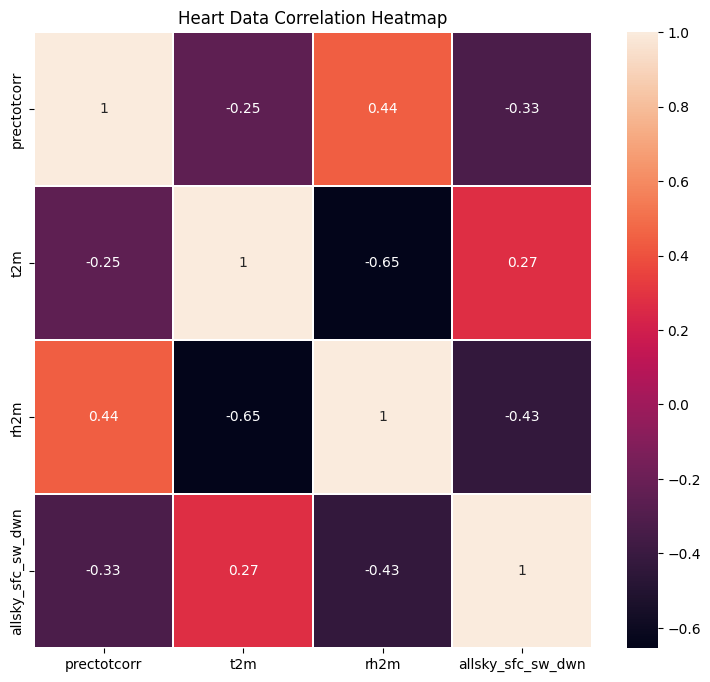

In [13]:
# Correlation Heatmap
plt.figure(figsize = (9,8))
plt.title("Heart Data Correlation Heatmap")
sns.heatmap(weather[numerical_weather].corr(), annot = True, linewidths = .1);


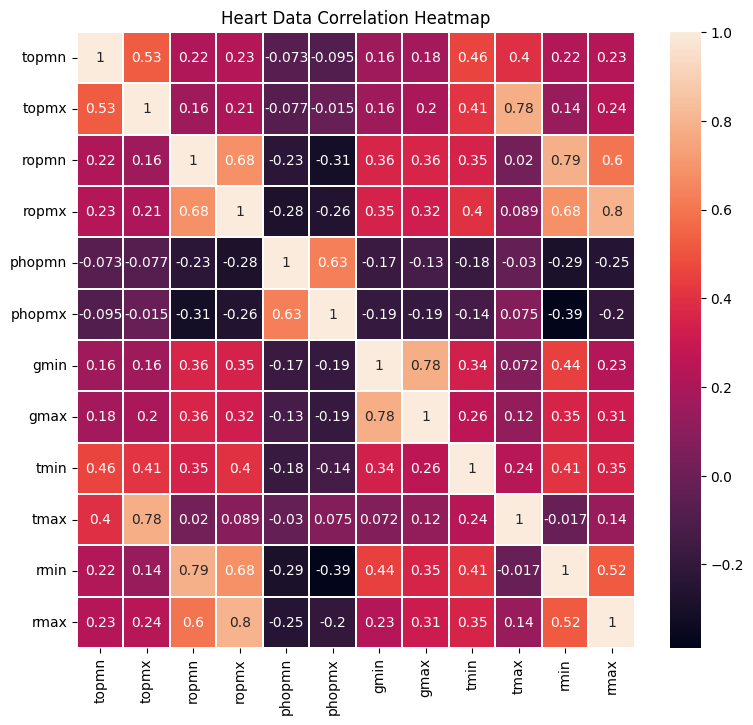

In [14]:
# Correlation Heatmap
plt.figure(figsize = (9,8))
plt.title("Heart Data Correlation Heatmap")
sns.heatmap(ecocrop[numerical_ecocrop].corr(), annot = True, linewidths = .1);


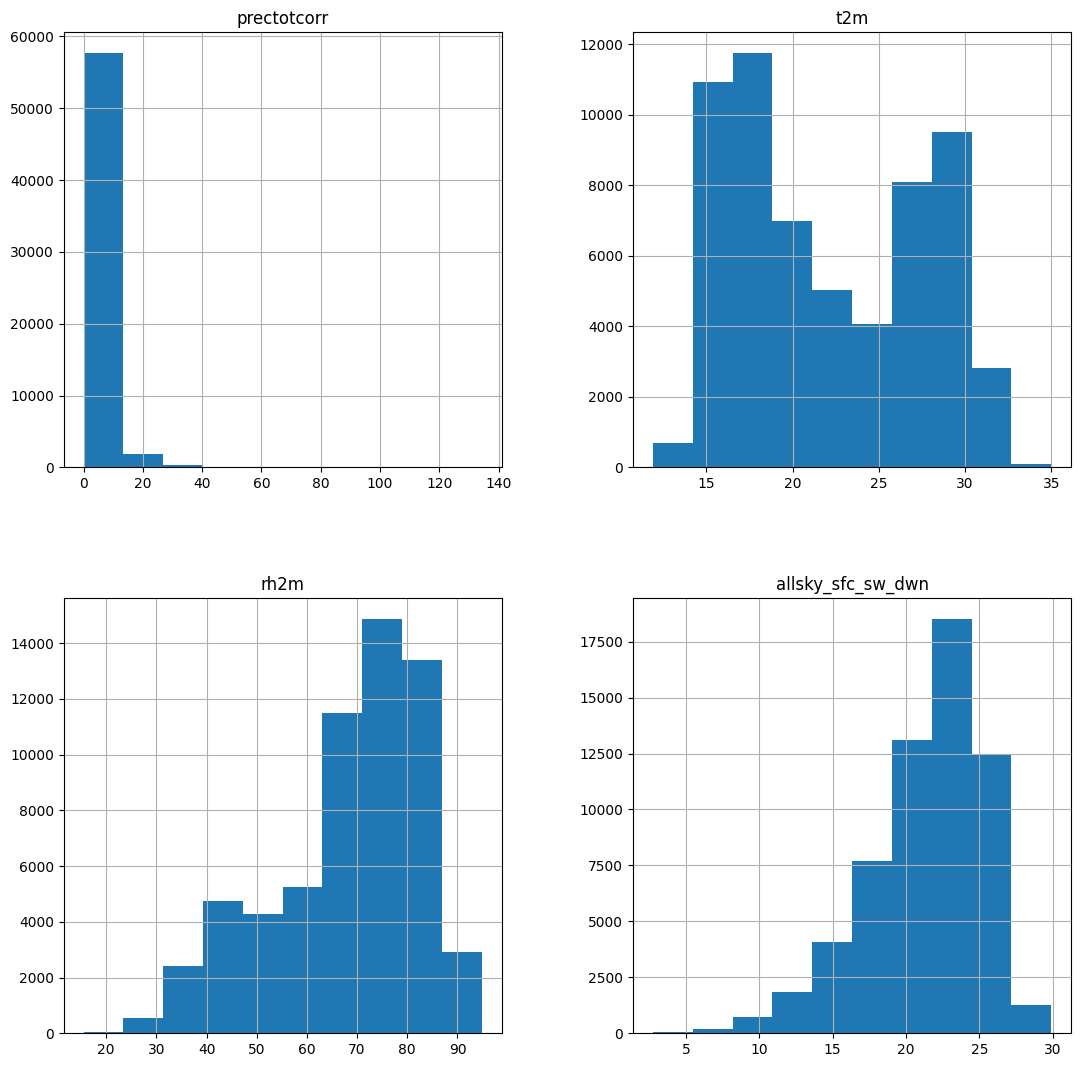

In [15]:
# Histograms of numerical variables
weather[numerical_weather].hist(figsize = (13, 13));

While the tmax and topmax variables below follows a normal distribution, all the others are skewed. That means for replacing missing values if we do so, it would be better to use medians.

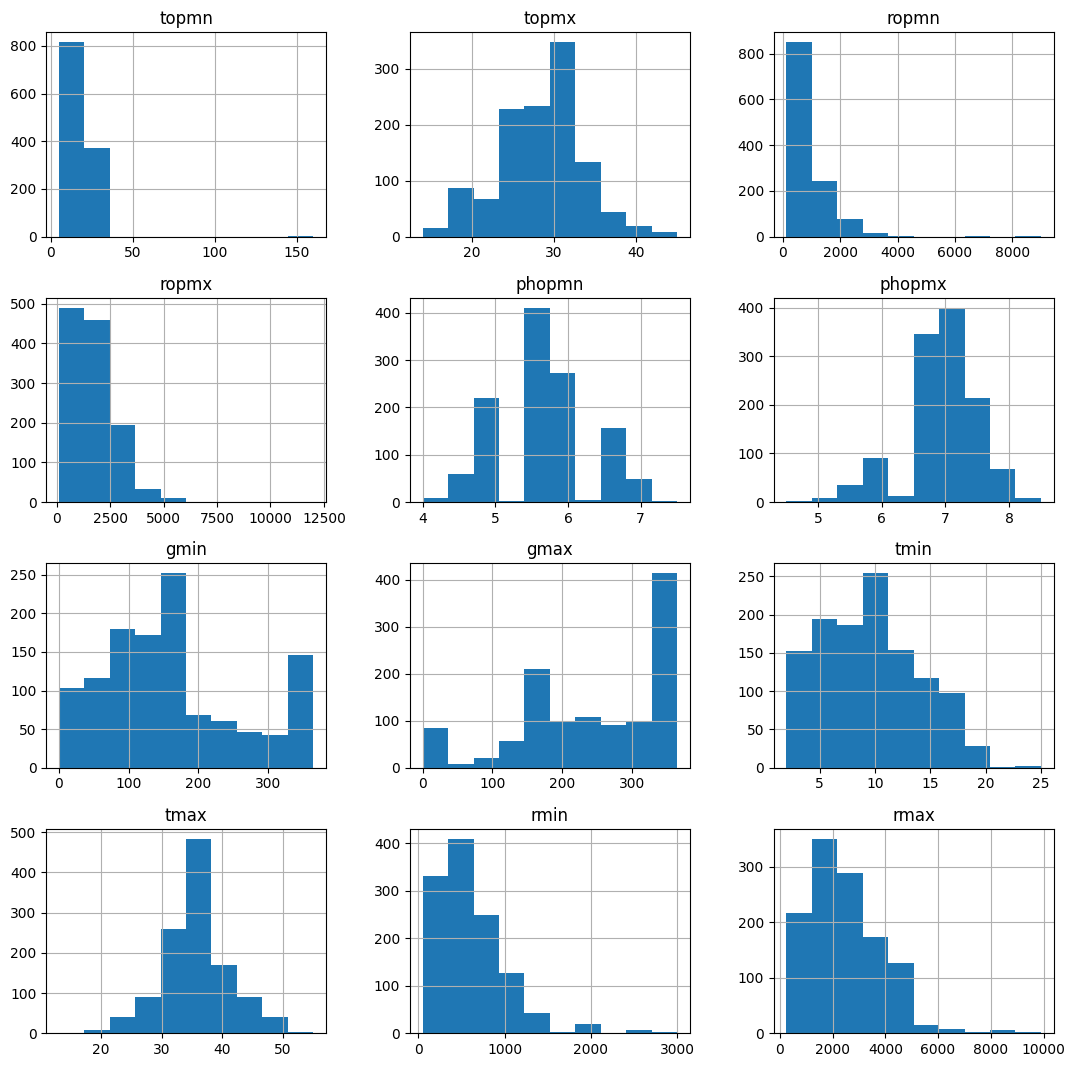

In [16]:
# Histograms of numerical variables
ecocrop[numerical_ecocrop].hist(figsize = (13, 13));

## Feature Engineering for Weather Data
Objective

Predict rainfall probability (classification)

Predict rainfall amount (regression)

Predict optimal planting window (binary classification: rain onset soon vs. not soon)

Preprocessing

In [17]:
weather['rain_binary'] = (weather['prectotcorr'] > 1).astype(int)
weather['month'] = pd.to_datetime(weather['date']).dt.month
# Define binary rain (threshold can be tuned)
weather['rain_class'] = (weather['prectotcorr'] > 1.0).astype(int)

## Visualize the target: rain /no rain

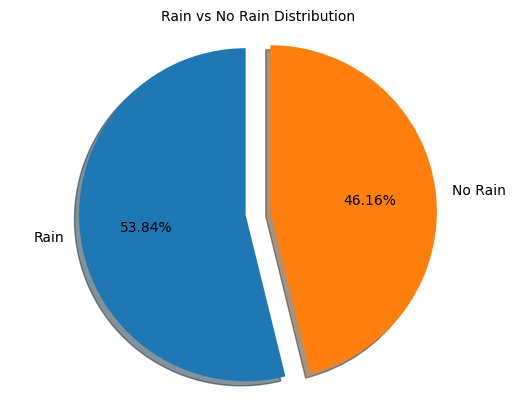

In [18]:
# Labels
labs_names = ['Rain','No Rain']
# Target value counts
data_counts = list(weather["rain_class"].value_counts())
# Space between pies
pie_space = (0.15, 0)
# Title
plt.title('Rain vs No Rain Distribution', fontsize = 10)
# Target variable distribution Pie chart
plt.pie(data_counts, explode = pie_space, labels = labs_names , autopct = '%1.2f%%',
        startangle = 90, shadow = True)
# Put title and plot on same axis
plt.axis('equal');

## Drop rows lacking essential features

In [19]:
weather.isnull().sum()

date                 0
prectotcorr          0
t2m                  0
rh2m                 0
allsky_sfc_sw_dwn    0
aez                  0
rain_binary          0
month                0
rain_class           0
dtype: int64

## Feature list for Models

In [20]:
# Feature list for models
features = ['T2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'month', 'AEZ']
features = [feature.lower() for feature in features]
features

['t2m', 'rh2m', 'allsky_sfc_sw_dwn', 'month', 'aez']

## Train Test Split

In [21]:
df_full_train, df_test = train_test_split(weather, test_size=0.20, random_state=1, shuffle=True)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, shuffle=True)
# resets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("sizes -> train:", len(df_train), "val:", len(df_val), "test:", len(df_test))



sizes -> train: 35976 val: 11992 test: 11992


## Extract your y values for classification(yes/no) and regression(How much)

In [22]:
# Extract y vectors
y_train_c = df_train['rain_class'].values
y_val_c = df_val['rain_class'].values
y_test_c = df_test['rain_class'].values

y_train_r = df_train['prectotcorr'].values
y_val_r = df_val['prectotcorr'].values
y_test_r = df_test['prectotcorr'].values

# Feature Importance Analysis
To evaluate feature importance, we can use the mutual information score for categorical variables, and the pearson correlation for numerical ones.

### Mutual Information
We calculate the mutual information scores (rounded to 5 decimals) between y and other categorical variables in the dataset, using the full train data set. We will define a function to ease the process.

In [23]:
# Function to get mutual information sore with respect to the churn
def mutual_info_y_score(series):
    """
    This function takes a series and returns the mutual information score
    with respect to the `y` variable of the full train data set.
    """
    return round(mutual_info_score(series, df_full_train["rain_class"]), 5)

In [24]:
# Apply mutual information columnwise to categorical variables
mi_scores = df_full_train[categorical_weather].apply(mutual_info_y_score)

# Sourt scores in ascending order
mi_scores.sort_values(ascending = False)

date    0.27711
aez     0.07426
dtype: float64

The date is more important feature than the aez in categorical features

### Pearson Correlation for numerical data
We calculate the mutual information scores (rounded to 2 decimals) between y and numerical variables in the dataset, using the full train data set:

In [25]:
# Absolute correlations between numerical columns and target
df_full_train[numerical_weather].corrwith(df_full_train["rain_class"]).abs().sort_values(ascending = False)

rh2m                 0.587671
prectotcorr          0.526944
t2m                  0.358527
allsky_sfc_sw_dwn    0.358045
dtype: float64

The most important numerical variabe is the rh2m Relative humidity at 2 meters above ground (%). , and the least one is the All-sky surface shortwave downward radiation (solar radiation reaching surface).

## Dict vectorizer One-hot encoding
Before training Machine Learning models, as they only understand numbers, we will encode all categorical variables in our datasets with One-Hot-Encoding. For this purpose, we will use Scikit-Learn vectorizer: DictVectorizer.

In [26]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(df_val[features].to_dict(orient='records'))
X_test = dv.transform(df_test[features].to_dict(orient='records'))


In [27]:
X_train[:,1].round(2), y_train_r

(array([0., 0., 0., ..., 0., 0., 1.], shape=(35976,)),
 array([2.03, 7.42, 0.77, ..., 0.67, 2.87, 1.1 ], shape=(35976,)))

## classification:(rain/no rain) try logistic, RF, XGBoost, pick best on validation
This block trains three different classification models:

Logistic Regression

Random Forest

XGBoost

Then it evaluates each on the validation set, tracks the accuracy, and keeps the best model.

In [28]:
classifiers = {
    "logreg": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_jobs=-1, random_state=1),
    #"xgb": XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method="hist")
}

## Looping Through Each Model to get the best one
best_clf: the best-performing classifier object

best_clf_name: a string like "rf"

best_acc: highest accuracy seen

First loop is for the key "rf", or "xgb" etc and the second loop is for the items ie the models themselves


In [29]:
best_clf = None
best_clf_name = None
best_acc = -1

for name, clf in classifiers.items():
    clf.fit(X_train, y_train_c)
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val_c, preds)
    print(f"classifier {name} val accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
        best_clf_name = name

print("Best classifier on val:", best_clf_name, best_acc)

classifier logreg val accuracy: 0.8150
classifier rf val accuracy: 0.8277
Best classifier on val: rf 0.8277184789859907


## Regressors - If yes then how much
The code compares:

RandomForestRegressor

XGBRegressor

on the validation set, using RMSE as the evaluation metric.

Whichever model gets the lowest RMSE is chosen as the best regressor.

In [30]:
regressors = {
    "rf_reg": RandomForestRegressor(n_jobs=-1, random_state=1),
    #"xgb_reg": XGBRegressor(tree_method="hist")
}

### Loop through each regression model
best_reg: best regressor model object

best_reg_name: string name like "xgb_reg"

best_rmse: stores the lowest RMSE found so far

initialized to infinity so ANY RMSE will be smaller

In [31]:
best_reg = None
best_reg_name = None
best_rmse = float("inf")

for name, reg in regressors.items():
    reg.fit(X_train, y_train_r)
    preds = reg.predict(X_val)
    rmse = mean_squared_error(y_val_r, preds)
    print(f"regressor {name} val RMSE: {rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_reg = reg
        best_reg_name = name

print("Best regressor on val:", best_reg_name, best_rmse)

regressor rf_reg val RMSE: 14.3037
Best regressor on val: rf_reg 14.30373759868162


## Fine tuning the random forest classifier
Random Forest Classifier
A Random Forest is a type of ensemble learning (approach using multiple models said weak learners to make predictions) that combines multiple decision trees. Each tree is trained on a different random subset of features, preventing all trees from being identical.

Remark:

For fine-tuning this model, we will focus on the number of trees (n_estimators) and the most important parameters for a decision tree: its maximum depth (max_depth) and its minimum number of leaves (min_samples_leaf). First, we will fine tune the number of trees and their depth together, so to determine the optimal depth and later, fine-tune the number of trees and their minimum number of leaves.

In [32]:
# Initialize scores
scores = []


# Possible number of estimators
n_params = np.arange(10, 201, 10)

# Random forest fine-tuning with maximum depth
for d in [5, 10, 15, 20, 25]:
    # Random forest fine-tuning with number of trees
    for n in n_params:
        # Initialize random forest classifier
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = d,
                                    random_state = 1,
                                    n_jobs = -1)
        # Model training
        rf.fit(X_train, y_train_c)

        # Make predictions
        y_pred = rf.predict(X_val)
        # accuracy score
        acc = 100 * (y_pred == y_val_c).mean()

        # Store hyperparameters and corresponding score
        scores.append((d, n, acc))

# Columns names
columns = ['max_depth', 'n_estimators', 'acc']
# Create a dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
# Let's get the rounded mean accuracy for each depth
df_scores.groupby("max_depth")["acc"].mean().round(3)

max_depth
5     80.814
10    83.263
15    83.313
20    82.743
25    82.671
Name: acc, dtype: float64

In [33]:
df_scores

,max_depth,n_estimators,acc
0,5,10,80.937292
1,5,20,80.987325
2,5,30,80.820547
3,5,40,80.712141
4,5,50,80.612075
...,...,...,...
95,25,160,82.805203
96,25,170,82.830220
97,25,180,82.830220
98,25,190,82.830220


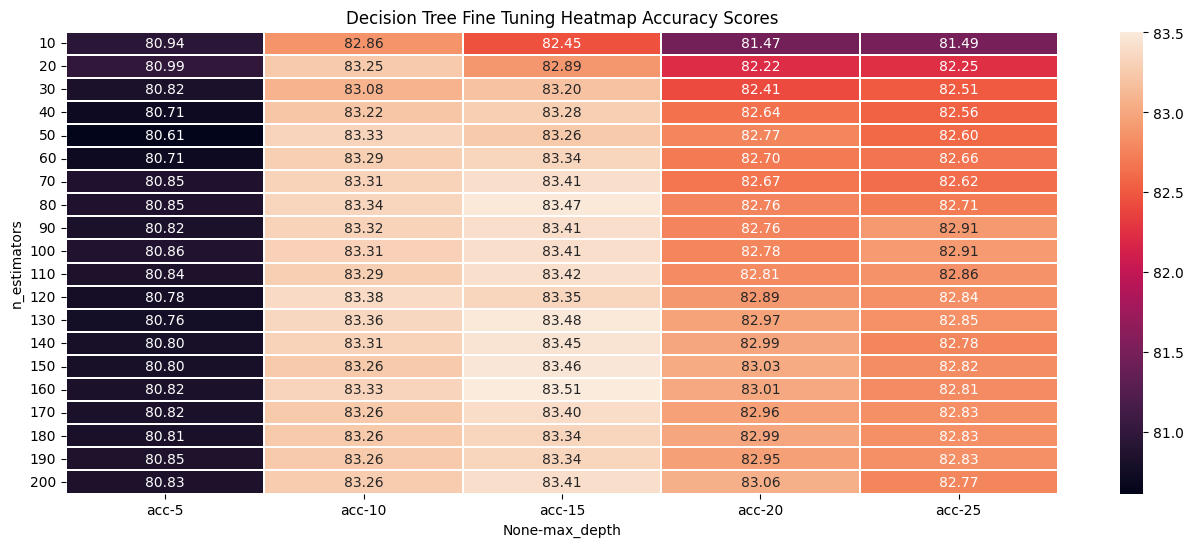

In [34]:
# Pivot table
df_scores_pivot = df_scores.pivot(index = 'n_estimators', columns = ['max_depth'], values = ['acc'])


# Scores Heatmap
plt.figure(figsize=(16, 6))
plt.title("Decision Tree Fine Tuning Heatmap Accuracy Scores")
sns.heatmap(df_scores_pivot, annot = True, fmt = ".2f", linewidths = .1);

In [35]:
max_depth = 15

# Initialize scores
scores = []

# Values for min_samples_leaf
min_sampl = [1, 3, 5, 10, 50]

# Fine-tunining with minimum samples per leaf
for s in min_sampl:
    # Fine-tuning with number of estimators
    for n in n_params:
        # Initialize model
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = 10,
                                    min_samples_leaf = s,
                                    random_state = 42,
                                    n_jobs = -1)
        # Model training
        rf.fit(X_train, y_train_c)

        # Make predictions
        y_pred = rf.predict(X_val)
        # accuracy score
        acc = 100 * (y_pred == y_val_c).mean()

        # Store hyperparameters and score
        scores.append((s, n, acc))

# Column names
columns = ['min_samples_leaf', 'n_estimators', 'acc']
# Create dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = ["acc", "n_estimators"], ascending = [False, True]).head(3)


,min_samples_leaf,n_estimators,acc
39,3,200,83.322215
28,3,90,83.313876
64,10,50,83.305537


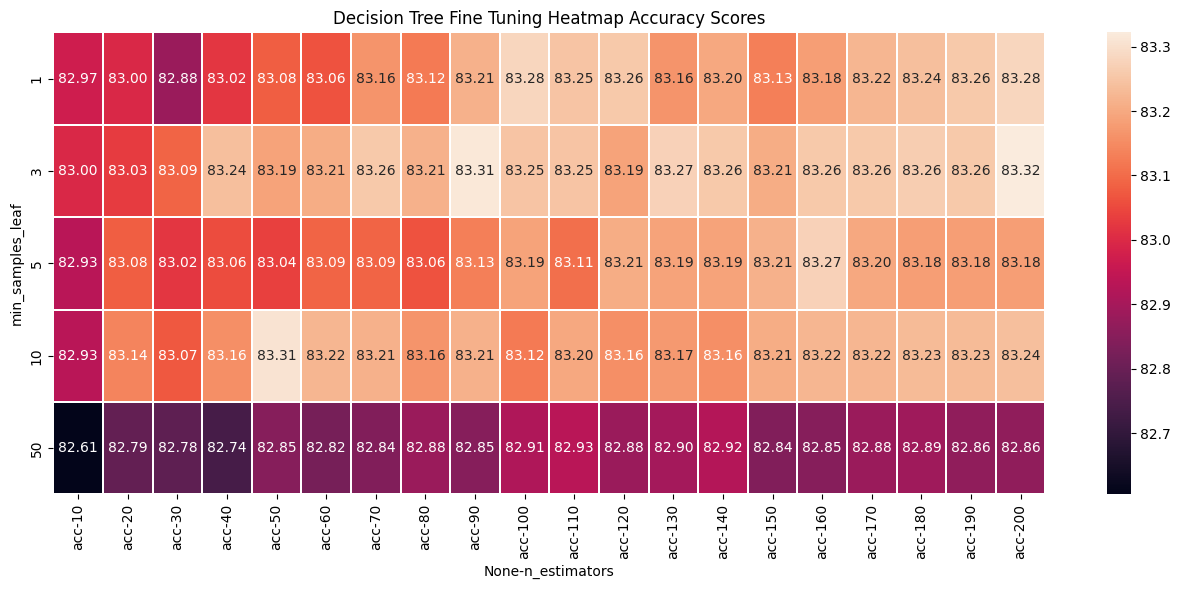

In [36]:
# Pivot table
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = ['n_estimators'], values = ['acc'])

# Scores Heatmap
plt.figure(figsize=(16, 6))
plt.title("Decision Tree Fine Tuning Heatmap Accuracy Scores")
sns.heatmap(df_scores_pivot, annot = True, fmt = ".2f", linewidths = .1);

Heatmaps are useful to visualize lower and higher numerical values faster, and in this particular case, it helps to identify the best parameters: 15 for the max_depth and 1 for the min_samples_leaf. The optimal decision tree gives an accuracy of

## Kfold for the best classifier{xgboost}
This code:

✔ Performs K-fold CrossValidation

✔ On ONLY the best model (xgboost)

✔ With proper preprocessing (DictVectorizer)

✔ Computes accuracy on each fold

✔ Shows the mean + stability (std deviation)

This provides a more reliable estimate than a single train/val split.

In [37]:
# %%
# K-Fold cross-validation for the chosen classifier (to check stability)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
fold_scores = []
print("Running K-Fold for", best_clf_name)

Running K-Fold for rf


In [38]:

for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train)):
    df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_va = df_full_train.iloc[val_idx].reset_index(drop=True)
    y_tr = df_tr['rain_class'].values
    y_va = df_va['rain_class'].values

    dv_fold = DictVectorizer(sparse=False)
    Xtr = dv_fold.fit_transform(df_tr[features].to_dict(orient='records'))
    Xva = dv_fold.transform(df_va[features].to_dict(orient='records'))

    # reinitialize classifier type (same class as best_clf)
    if best_clf_name == "rf":
        clf_fold = RandomForestClassifier(n_jobs=-1, random_state=42)
    elif best_clf_name == "logreg":
        clf_fold = LogisticRegression(max_iter=1000, solver='liblinear')
    else:
        clf_fold = XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method="hist")

    clf_fold.fit(Xtr, y_tr)
    preds = clf_fold.predict(Xva)
    acc = accuracy_score(y_va, preds)
    fold_scores.append(acc)
    print(f"fold {fold} acc: {acc:.4f}")

print("KFold acc mean: %.4f std: %+-.4f" % (np.mean(fold_scores), np.std(fold_scores)))

fold 0 acc: 0.8322
fold 1 acc: 0.8358
fold 2 acc: 0.8328
fold 3 acc: 0.8396
fold 4 acc: 0.8303
KFold acc mean: 0.8341 std: +0.0032


## Final training on full training datasets

In [39]:
dv_final = DictVectorizer(sparse=False)
X_full = dv_final.fit_transform(df_full_train[features].to_dict(orient='records'))


## Hyperparameter tuning

In [50]:
if best_clf_name == "rf":
    final_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
if best_clf_name == "logreg":
    final_clf = LogisticRegression(max_iter=1000, solver='liblinear')
# else:
#     # final_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method="hist")
#     continue

final_clf.fit(X_full, df_full_train['rain_class'].values)


RandomForestClassifier(n_jobs=-1, random_state=42)

## Final regressor

In [51]:
# Final regressor: retrain on full train
final_reg = best_reg.__class__(**getattr(best_reg, 'get_params', lambda: {})())
final_reg.set_params(**{k:v for k,v in getattr(best_reg, 'get_params', lambda: {})().items()}) if hasattr(best_reg, 'get_params') else None
final_reg.fit(X_full, df_full_train['prectotcorr'].values)


RandomForestRegressor(n_jobs=-1, random_state=1)

## Evaluate on holdout test dataset
✔ Converts the test set into numeric feature vectors
✔ Uses the same vectorizer fit on the training data
✔ Avoids data leakage
✔ Makes predictions
✔ Computes test accuracy for the classifier
✔ Compares actual vs predicted class labels

In [52]:
X_test_final = dv_final.transform(df_test[features].to_dict(orient='records'))
test_acc = accuracy_score(df_test['rain_class'].values, final_clf.predict(X_test_final))
test_rmse = mean_squared_error(df_test['prectotcorr'].values, final_reg.predict(X_test_final))
print("Test accuracy (classifier):", round(test_acc,4))
print("Test RMSE (regressor):", round(test_rmse,4))


Test accuracy (classifier): 0.8336
Test RMSE (regressor): 16.5066


## saving the weather models
why save 3 objects:

A preprocessing object

A classification model

A regression model

Each is needed for a different task and cannot replace the others.

In [67]:
import os
import joblib

os.makedirs("../models", exist_ok=True)

joblib.dump(dv_final, "../models/dict_vectorizer.bin", compress=5)
joblib.dump(final_clf, "../models/rain_classifier.bin", compress=5)
joblib.dump(final_reg, "../models/rain_regressor.bin", compress=5)

print("Saved models with compression")


Saved models with compression


In [57]:
print(type(final_reg))
print(final_reg)


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
RandomForestRegressor(n_jobs=-1, random_state=1)


## simple crop recommendation(rule based)
Prints Ecocrop columns

Identifies the key numeric ecological tolerance fields ie temperature and rainfall columns are numeric

Converts them cleanly to numeric

Replaces invalid values with NaN (safe for filtering)

Prepares the dataset for rule-based crop suitability matching

In [54]:
# %%
# Simple crop recommender using ecocrop ranges (rule-based)
# ecocrop columns assumed to include: ScientificName, TOPMN, TOPMX, RMIN, RMAX, maybe PH ranges etc.
# We'll use mean T and mean Rain for location and check crop ranges.

ecocrop_cols = ecocrop.columns.tolist()
print("ecocrop columns:", ecocrop_cols[:20])

# Ensure numeric columns exist and coerce
for col in ['TOPMN','TOPMX','RMIN','RMAX','TMIN','TMAX']:
    if col in ecocrop.columns:
        ecocrop[col] = pd.to_numeric(ecocrop[col], errors='coerce')

ecocrop columns: ['comname', 'scientificname', 'dra', 'cat', 'fer', 'sal', 'topmn', 'topmx', 'ropmn', 'ropmx', 'phopmn', 'phopmx', 'gmin', 'gmax', 'tmin', 'tmax', 'rmin', 'rmax']


## What This Function Is: A Rule-Based Crop Recommender

This function takes:

the site’s mean temperature (site_temp)

the site’s mean rainfall (site_rain)

an Ecocrop dataset (ecocrop_df)

an optional tolerance

It returns all crops whose Ecocrop suitability ranges include the given site conditions.

This is a simple range-matching crop suitability algorithm.

Inputs:
site_temp: average temperature at the location
site_rain: average rainfall at the location
ecocrop_df: Ecocrop database
tolerance: extra looseness on each range (absolute buffer)

In [55]:
# Recommender: returns crops whose ranges include the given site values (T_mean in degC, R_mean in mm)
def recommend_crops(site_temp, site_rain, ecocrop_df, tolerance=0.0):
    """
    Return crops where site_temp in [TMIN - tol, TMAX + tol] and site_rain in [RMIN - tol, RMAX + tol].
    tolerance can be fractional proportion or absolute depending on range presence; using absolute here.
    """
    candidates = []
    for _, row in ecocrop_df.iterrows():
        try:
            #Extract the crop’s suitability ranges
            tmin = row.get('tmin', np.nan)
            tmax = row.get('tmax', np.nan)
            rmin = row.get('rmin', np.nan)
            rmax = row.get('rmax', np.nan)
            #Skip if any important value is missing
            if np.isnan(tmin) or np.isnan(tmax) or np.isnan(rmin) or np.isnan(rmax):
                continue
            #5. Check whether the site conditions fall inside the crop’s tolerances
            if (site_temp >= (tmin - tolerance)) and (site_temp <= (tmax + tolerance)) \
               and (site_rain >= (rmin - tolerance)) and (site_rain <= (rmax + tolerance)):
               # Append crop name if suitable
                candidates.append(row['scientificname'] if 'scientificname' in row else row.get('comname', None))
        except Exception:
            continue
        # Remove None values and return the list
    return list(filter(lambda x: x is not None, candidates))


## saving the plant recommendation model

In [68]:
os.makedirs("../models", exist_ok=True)

# Save ecocrop with compression
joblib.dump(ecocrop, "../models/ecocrop_df.bin", compress=3)

print("Saved ecocrop_df.bin (compressed) to ../models")

Saved ecocrop_df.bin (compressed) to ../models


In [47]:
weather.columns.to_list()

['date',
 'prectotcorr',
 't2m',
 'rh2m',
 'allsky_sfc_sw_dwn',
 'aez',
 'rain_binary',
 'month',
 'rain_class']

## Testing if a running model replies

In [64]:
import requests
import pandas as pd

# Pick a sample row
sample_idx = 5  # or min(50, len(weather)-1)
sample_row = weather.iloc[sample_idx]

# Map the dataframe columns to the API's expected keys
sample_dict_api = {
    "T2M": float(sample_row["t2m"]),
    "RH2M": float(sample_row["rh2m"]),
    "ALLSKY_SFC_SW_DWN": float(sample_row["allsky_sfc_sw_dwn"]),
    "month": int(sample_row["month"]),
    "AEZ": sample_row["aez"]
}

# URL of the running FastAPI endpoint
url = "http://127.0.0.1:8003/predict_weather"

# Send POST request
response = requests.post(url, json=sample_dict_api)

# Print results
if response.status_code == 200:
    print("Sample index:", sample_idx)
    print("Input features:", sample_dict_api)
    print("API prediction:", response.json())
else:
    print("Error:", response.status_code, response.text)


Sample index: 5
Input features: {'T2M': 15.56, 'RH2M': 85.0, 'ALLSKY_SFC_SW_DWN': 16.54, 'month': 1, 'AEZ': 'Highlands (Humid)'}
API prediction: {'rain_probability': 0.6694862246513367, 'predicted_precipitation': 11.816999999999998}


### crop testing


In [65]:
import requests
import pandas as pd
import numpy as np

# Pick a sample row
sample_idx = 50  # or min(50, len(ecocrop)-1)
sample_row = ecocrop.iloc[sample_idx]

# Map dataframe columns to API input
sample_dict_api = {
    "site_temp": float(sample_row["tmin"] + sample_row["tmax"]) / 2,  # use mean temp
    "site_rain": float(sample_row["rmin"] + sample_row["rmax"]) / 2,  # use mean rain
    "tolerance": 0.0
}

# URL of the running FastAPI endpoint
url = "http://127.0.0.1:8003/recommend_crops"

# Send POST request
response = requests.post(url, json=sample_dict_api)

# Print results
if response.status_code == 200:
    print("Sample index:", sample_idx)
    print("Input features:", sample_dict_api)
    print("Recommended crops:", response.json())
else:
    print("Error:", response.status_code, response.text)


Sample index: 50
Input features: {'site_temp': 32.5, 'site_rain': 2000.0, 'tolerance': 0.0}
Recommended crops: {'recommended_crops': ['Abelmoschus esculentus', 'Abelmoschus manihot', 'Acacia auriculiformis', 'Acacia farnesiana', 'Adenanthera pavonina', 'Aeschynomene americana', 'Agathis macrophylla', 'Agathis robusta', 'Albizia lebbeck', 'Albizia stipulata', 'Allium sativum', 'Alstonia scholaris', 'Amaranthus cruentus', 'Amaranthus sp.', 'Anacardium occidentale', 'Ananas comosus', 'Annona muricata', 'Annona reticulata', 'Annona squamosa', 'Araucaria cunninghamii', 'Areca catechu', 'Artocarpus heterophyllus', 'Asparagus officinalis', 'Asystasia gangetica', 'Averrhoa bilimbi', 'Averrhoa carambola', 'Barringtonia racemosa', 'Basella alba', 'Basella rubra', 'Bauhinia variegata', 'Benincasa hispida', 'Bidens pilosa', 'Bixa orellana', 'Bothriochloa bladhii', 'Brachiaria brizantha', 'Brachiaria decumbens', 'Brachiaria humidicola', 'Brachiaria miliiformis', 'Brachiaria mutica', 'Brachiaria ruz

## Testing from docker

In [66]:
import pandas as pd
import requests

# -------------------------
# Weather API
# -------------------------
sample_idx = 5
sample_row = weather.iloc[sample_idx]

payload = {
    "T2M": float(sample_row["t2m"]),
    "RH2M": float(sample_row["rh2m"]),
    "ALLSKY_SFC_SW_DWN": float(sample_row["allsky_sfc_sw_dwn"]),
    "month": int(sample_row["month"]),
    "AEZ": str(sample_row["aez"])
}

weather_url = "http://127.0.0.1:8003/predict_weather"
response = requests.post(weather_url, json=payload)

if response.status_code == 200:
    print("Weather API Prediction:", response.json())
else:
    print("Weather API Error:", response.status_code, response.text)

# -------------------------
# Crops API
# -------------------------
sample_idx_crop = 100
sample_crop = ecocrop.iloc[sample_idx_crop]

crops_payload = {
    "site_temp": float((sample_crop["tmin"] + sample_crop["tmax"]) / 2),
    "site_rain": float((sample_crop["rmin"] + sample_crop["rmax"]) / 2),
    "tolerance": 0.0
}

crops_url = "http://127.0.0.1:8003/recommend_crops"
response_crops = requests.post(crops_url, json=crops_payload)

if response_crops.status_code == 200:
    print("Crops API Recommendation:", response_crops.json())
else:
    print("Crops API Error:", response_crops.status_code, response_crops.text)


Weather API Prediction: {'rain_probability': 0.6694862246513367, 'predicted_precipitation': 11.816999999999998}
Crops API Recommendation: {'recommended_crops': ['Abelmoschus esculentus', 'Abelmoschus manihot', 'Acacia auriculiformis', 'Acacia farnesiana', 'Adenanthera pavonina', 'Aeschynomene americana', 'Agathis macrophylla', 'Agathis robusta', 'Albizia lebbeck', 'Albizia stipulata', 'Aleurites moluccana', 'Allium ampeloprasum', 'Allium cepa', 'Allium fistulosum', 'Allium sativum', 'Alstonia scholaris', 'Amaranthus cruentus', 'Amaranthus sp.', 'Anacardium occidentale', 'Ananas comosus', 'Annona muricata', 'Annona reticulata', 'Annona squamosa', 'Apium graveolens var. dulce', 'Araucaria cunninghamii', 'Areca catechu', 'Artocarpus heterophyllus', 'Asparagus officinalis', 'Asystasia gangetica', 'Averrhoa bilimbi', 'Averrhoa carambola', 'Bambusa vulgaris', 'Basella alba', 'Basella rubra', 'Bauhinia variegata', 'Benincasa hispida', 'Bidens pilosa', 'Bixa orellana', 'Brachiaria brizantha', 